In [23]:
from matplotlib import pyplot as plt
import cv2
import a4_utils;
import numpy as np
import math
from PIL import Image

# Exercise1

## Task A

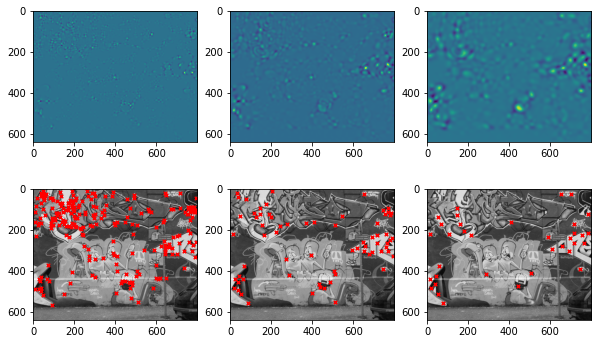

In [24]:
#This function is copied from the assignment3
#thresh -> points lower than it we just ignore
#size -> amount of pixels we check on each side
def nonmaxima_suppression_box(I, thresh, size=1):
    #The idea is similar to the 2d median from assignment2
    result = np.zeros_like(I) #Create a 0s array 
    I = np.pad(I, size) #Pad I with 1 layer of 0s
    for j in range(result.shape[0]):
        for i in range(result.shape[1]):
            if(I[j+size,i+size] < thresh):
                continue
            #If the pixel is higher than 0 we compare it to the pixels around it
            temp = np.copy(I[j:j+(2*size+1),i:i+(2*size+1)])
            temp[size,size] = 0
            max_neighbor = np.max(temp)
            if(I[j+size,i+size] > max_neighbor):
                #If the pixel is higher than all of it's neighbors we keep it
                result[j,i] = I[j+size,i+size]
            elif(I[j+size,i+size] == max_neighbor):
                I[j+size,i+size] = 0

    return result


#A function that will give us all first and second image derivatives (we need them often)
def derivatives(I, sigma):
    G = a4_utils.gauss(sigma)
    D = a4_utils.gaussdx(sigma)
    Ix = cv2.filter2D(src=cv2.filter2D(src=I, ddepth=-1, kernel=G.T), ddepth=-1, kernel=D)
    Iy = cv2.filter2D(src=cv2.filter2D(src=I, ddepth=-1, kernel=G), ddepth=-1, kernel=D.T)
    Ixx = cv2.filter2D(src=cv2.filter2D(src=Ix, ddepth=-1, kernel=G.T), ddepth=-1, kernel=D)
    Iyy = cv2.filter2D(src=cv2.filter2D(src=Iy, ddepth=-1, kernel=G), ddepth=-1, kernel=D.T)
    Ixy = cv2.filter2D(src=cv2.filter2D(src=Ix, ddepth=-1, kernel=G), ddepth=-1, kernel=D.T)
    return Ix,Iy,Ixx,Iyy,Ixy


def hessian_points(I, sigma, thresh=0.004):
    _, _, Ixx, Iyy, Ixy = derivatives(I,sigma)
    #Just following the formula
    H = Ixx * Iyy - Ixy**2
    #We then do a non_max_supp and thresholding on it
    Hmax = nonmaxima_suppression_box(H, thresh)
    #And we return a touple (H is just for displaying), (np.nonzero(Hmax) will give us the coords of feature points)
    return H, np.nonzero(Hmax)

def task_a(image="./data/graf/graf_a.jpg"):
    I = np.asarray(Image.open(image).convert("L")).astype(np.float64) / 255

    plt.figure(figsize=(10,6))
    for i in range(1,4):
        H, fPoints = hessian_points(I, 3*i)

        plt.subplot(2,3,i)
        plt.imshow(H)

        plt.subplot(2,3,i+3)
        plt.imshow(I, cmap="gray")
        plt.scatter(fPoints[1], fPoints[0], color="red", s=1, marker="x", linewidths=5)

    plt.show()

task_a()

## Task b

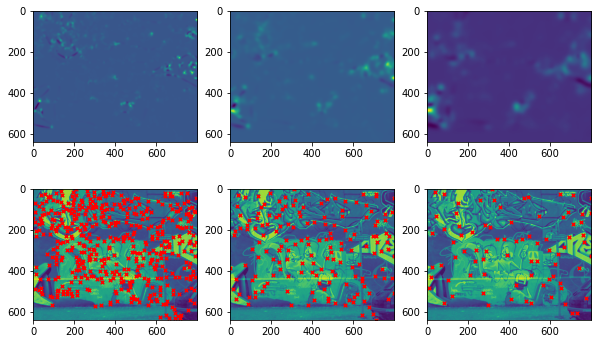

In [25]:
def harris_points(I, sigma, alpha = 0.06, thresh = 0.000001):
    Ix, Iy, _, _, Ixy = derivatives(I,sigma)
    G = a4_utils.gauss(sigma*1.6)
    #Again, following the formula, C is a 2x2 matrix which elements are Cx, Cy and 2x Cxy
    Cx = cv2.filter2D(src=cv2.filter2D(src=Ix**2, ddepth=-1, kernel=G), ddepth=-1, kernel=G.T)
    Cy = cv2.filter2D(src=cv2.filter2D(src=Iy**2, ddepth=-1, kernel=G), ddepth=-1, kernel=G.T)
    Cxy = cv2.filter2D(src=cv2.filter2D(src=Ix*Iy, ddepth=-1, kernel=G), ddepth=-1, kernel=G.T)

    #Then we calculate the matrix determinant and trace (basic linear algebra)
    detC = Cx * Cy - Cxy**2
    traceC = Cx + Cy

    #And again follow the formula and do a non_max_supp
    C = detC - alpha * traceC**2

    #And we return a touple (C is just for displaying), (np.nonzero(Cmax) will give us the coords of feature points)
    Cmax = nonmaxima_suppression_box(C, thresh)

    return C, np.nonzero(Cmax)

def task_b(image="./data/graf/graf_a.jpg"):
    I = np.asarray(Image.open(image).convert("L")).astype(np.float64) / 255

    plt.figure(figsize=(10,6))
    for i in range(1,4):
        C, fPoints = harris_points(I, i*3)

        plt.subplot(2,3,i)
        plt.imshow(C)

        plt.subplot(2,3,i+3)
        plt.imshow(I)
        plt.scatter(fPoints[1], fPoints[0], color="red", s=1, marker="x", linewidths=5)

    plt.show()

task_b()

# Exercise 2

## Task a

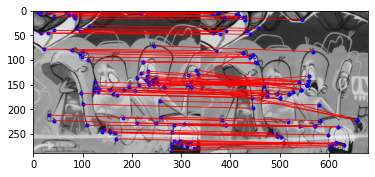

In [26]:
def find_correspondences(desc1, desc2):
    #For each descriptor from the first image we...
    pairs = []
    for i,desc in enumerate(desc1):
        #calculate the hellinger distance between it and all descriptors from the second image
        #(axis=1 tells the sum function to only sum elements on the axis 1 -> gives us a 1d array of sums -> we get an array of distances and not just 1 distance)
        dist = np.sqrt(np.sum((np.sqrt(desc) - np.sqrt(desc2))**2, axis=1) / 2)
        #we store the indexes of dest1 and dest2 descriptors whose distance was the smallest
        pairs.append([i,np.where(dist == dist.min())[0][0]])

    return pairs

def task_a():
    I1 = np.asarray(Image.open("data\graf\graf_a_small.jpg").convert("L")).astype(np.float64) / 255
    I2 = np.asarray(Image.open("data\graf\graf_b_small.jpg").convert("L")).astype(np.float64) / 255

    #We get the feature points using the hessian detector
    
    sigma = 2
    _, fPoints1 = hessian_points(I1, sigma)
    _, fPoints2 = hessian_points(I2, sigma)

    # sigma = 5
    # _, fPoints1 = harris_points(I1, sigma)
    # _, fPoints2 = harris_points(I2, sigma)

    #We get the descriptors from out feature points
    desc1 = a4_utils.simple_descriptors(I1, fPoints1[0], fPoints1[1], radius=30, sigma=2)
    desc2 = a4_utils.simple_descriptors(I2, fPoints2[0], fPoints2[1], radius=30, sigma=2)

    #we get a list of pairs which represent indexes in fPoints arrays 
    #So for example pairs[0] = [x1,x2] means that the first pair of points is 
    #[fPoints1[1][x1], fPoints1[0][x1]] and [fPoints2[1][x2], fPoints2[0][x2]]
    correspondences = find_correspondences(desc1, desc2)

    points1 = []
    points2 = []
    for x1, x2 in correspondences:
        points1.append([fPoints1[1][x1], fPoints1[0][x1]])
        points2.append([fPoints2[1][x2], fPoints2[0][x2]])

    a4_utils.display_matches(I1, points1, I2, points2)

task_a()

## Task b

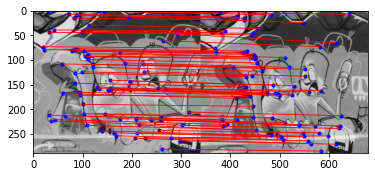

In [27]:
def find_correspondences_symetric(desc1, desc2):
    #For each descriptor from the first image we...
    firstPairs = []
    for i,desc in enumerate(desc1):
        #calculate the hellinger distance between it and all descriptors from the second image
        #(axis=1 tells the sum function to only sum elements on the axis 1 -> gives us a 1d array of sums -> we get an array of distances and not just 1 distance)
        dist = np.sqrt(np.sum((np.sqrt(desc) - np.sqrt(desc2))**2, axis=1) / 2)
        #we store the indexes of dest1 and dest2 descriptors whose distance was the smallest
        firstPairs.append([i,np.where(dist == dist.min())[0][0]])

    #Same for the second image we ...
    secondPairs = []
    for i,desc in enumerate(desc2):
        #calculate the hellinger distance between it and all descriptors from the first image
        #(axis=1 tells the sum function to only sum elements on the axis 1 -> gives us a 1d array of sums -> we get an array of distances and not just 1 distance)
        dist = np.sqrt(np.sum((np.sqrt(desc) - np.sqrt(desc1))**2, axis=1) / 2)
        #we store the indexes of dest1 and dest2 descriptors whose distance was the smallest
        secondPairs.append([i,np.where(dist == dist.min())[0][0]])

    #We now have pairs from first and second image
    firstPairs = np.asarray(firstPairs)
    secondPairs = np.flip(secondPairs, axis=1)
    #We convert these arrays to sets, and keep only the matching pairs
    pairs = np.array([x for x in set(tuple(x) for x in firstPairs) & set(tuple(x) for x in secondPairs)])
    return pairs


def find_matches(I1, I2, sigma, detector="hessian", radius=30, descSigma = 2):

    if(detector == "hessian"):
        _, fPoints1 = hessian_points(I1, sigma)
        _, fPoints2 = hessian_points(I2, sigma)
    else:
        _, fPoints1 = harris_points(I1, sigma)
        _, fPoints2 = harris_points(I2, sigma)

    #We get the descriptors from out feature points
    desc1 = a4_utils.simple_descriptors(I1, fPoints1[0], fPoints1[1], radius=radius, sigma=descSigma)
    desc2 = a4_utils.simple_descriptors(I2, fPoints2[0], fPoints2[1], radius=radius, sigma=descSigma)

    #We find symetric correspondences (desc1 matched with desc2 and the other way round)
    correspondences = find_correspondences_symetric(desc1, desc2)

    points1 = []
    points2 = []
    for x1, x2 in correspondences:
        points1.append([fPoints1[1][x1], fPoints1[0][x1]])
        points2.append([fPoints2[1][x2], fPoints2[0][x2]])

    #We return the matching points for each image
    return points1, points2


def task_b():
    I1 = np.asarray(Image.open("data\graf\graf_a_small.jpg").convert("L")).astype(np.float64) / 255
    I2 = np.asarray(Image.open("data\graf\graf_b_small.jpg").convert("L")).astype(np.float64) / 255

    points1, points2 = find_matches(I1, I2, 1)


    a4_utils.display_matches(I1, points1, I2, points2)

task_b()

## Task c

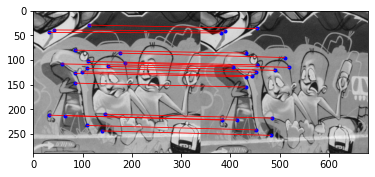

In [28]:
#I used the idea from the lectures, where we only keep those correspondences, which are very similar to eachother
#but not so similar to any other points, which ensures us, that we don't use any correspondences for which we are
#not sure to which point does it translate to. (Full description = presentation 5, slide 88)


def find_correspondences_symetric_snd_most_similar(desc1, desc2):
    #For each descriptor from the first image we...
    firstPairs = []
    for i,desc in enumerate(desc1):
        #calculate the hellinger distance between it and all descriptors from the second image
        #(axis=1 tells the sum function to only sum elements on the axis 1 -> gives us a 1d array of sums -> we get an array of distances and not just 1 distance)
        dist = np.sqrt(np.sum((np.sqrt(desc) - np.sqrt(desc2))**2, axis=1) / 2)
        #we get the 2 smallest distances of descriptors (2 most similar descriptors)
        fst_min_dist, snd_min_dist = np.partition(dist, 1)[:2]
        #We check if the ration of these 2 distances is less than 0.8 (the smaller the ratio, the more distinctive the key-point is, which is what we want)
        if(fst_min_dist/snd_min_dist < 0.8):
            #we store the indexes of dest1 and dest2 descriptors whose distance was the smallest
            firstPairs.append([i,np.where(dist == dist.min())[0][0]])

    #Same for the second image we ...
    secondPairs = []
    for i,desc in enumerate(desc2):
        #calculate the hellinger distance between it and all descriptors from the first image
        #(axis=1 tells the sum function to only sum elements on the axis 1 -> gives us a 1d array of sums -> we get an array of distances and not just 1 distance)
        dist = np.sqrt(np.sum((np.sqrt(desc) - np.sqrt(desc1))**2, axis=1) / 2)
        #we get the 2 smallest distances of descriptors (2 most similar descriptors)
        fst_min_dist, snd_min_dist = np.partition(dist, 1)[:2]
        #We check if the ration of these 2 distances is less than 0.8 (the smaller the ratio, the more distinctive the key-point is, which is what we want)
        if(fst_min_dist/snd_min_dist < 0.8):
            #we store the indexes of dest1 and dest2 descriptors whose distance was the smallest
            secondPairs.append([i,np.where(dist == dist.min())[0][0]])

    #We now have pairs from first and second image
    firstPairs = np.asarray(firstPairs)
    secondPairs = np.flip(secondPairs, axis=1)
    #We convert these arrays to sets, and keep only the matching pairs
    pairs = np.array([x for x in set(tuple(x) for x in firstPairs) & set(tuple(x) for x in secondPairs)])
    return pairs

#I increased the descSigma for find_matches_2 from 2 to 6 to get more descriptors
def find_matches_2(I1, I2, sigma, detector="hessian", radius=30, descSigma = 6):

    if(detector == "hessian"):
        _, fPoints1 = hessian_points(I1, sigma)
        _, fPoints2 = hessian_points(I2, sigma)
    else:
        _, fPoints1 = harris_points(I1, sigma)
        _, fPoints2 = harris_points(I2, sigma)

    #We get the descriptors from out feature points
    desc1 = a4_utils.simple_descriptors(I1, fPoints1[0], fPoints1[1], radius=radius, sigma=descSigma)
    desc2 = a4_utils.simple_descriptors(I2, fPoints2[0], fPoints2[1], radius=radius, sigma=descSigma)

    #We find symetric correspondences (desc1 matched with desc2 and the other way round)
    correspondences = find_correspondences_symetric_snd_most_similar(desc1, desc2)

    points1 = []
    points2 = []
    for x1, x2 in correspondences:
        points1.append([fPoints1[1][x1], fPoints1[0][x1]])
        points2.append([fPoints2[1][x2], fPoints2[0][x2]])

    #We return the matching points for each image
    return points1, points2


def task_c():
    I1 = np.asarray(Image.open("data\graf\graf_a_small.jpg").convert("L")).astype(np.float64) / 255
    I2 = np.asarray(Image.open("data\graf\graf_b_small.jpg").convert("L")).astype(np.float64) / 255

    points1, points2 = find_matches_2(I1, I2, 1)


    a4_utils.display_matches(I1, points1, I2, points2)

task_c()


## Task e

In [29]:
#https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html
#https://learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

#why ORB: more efficient that SIFT and SURF, it's rotation invariant unlike FAST

def task_e():
    video = cv2.VideoCapture("data/video.mp4")
    orb = cv2.ORB_create(nfeatures=100, scoreType=cv2.ORB_FAST_SCORE)

    #Check if video opened successfully
    if (video.isOpened()== False): 
        print("Error opening the video/file")
    
    # Read until video is completed
    while(video.isOpened()):
        # Capture frame-by-frame
        ret, frame = video.read()
        if ret == True:
            key_points = orb.detect(frame, None)
            # Display the resulting frame with the keypoints on it
            cv2.imshow('video',cv2.drawKeypoints(frame, key_points, frame))
            # Press Q on keyboard to exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        # Break the loop
        else: 
            break
    
    # When everything done, release the video capture object
    video.release()
    cv2.destroyAllWindows()

task_e()

# Exercise 3

In [30]:
def display_matches_copy(I1, pts1, I2, pts2):
	"""
	Displays matches between images.

	I1, I2: Image in grayscale.
	pts1, pts2: Nx2 arrays of coordinates of feature points for each image (first columnt is x, second is y coordinates)
	"""

	assert I1.shape[0] == I2.shape[0] and I1.shape[1] == I2.shape[1], "Images need to be of the same size."

	I = np.hstack((I1, I2))
	w = I1.shape[1]
	plt.imshow(I, cmap='gray')

	for p1, p2 in zip(pts1, pts2):
		x1 = p1[0]
		y1 = p1[1]
		x2 = p2[0]
		y2 = p2[1]
		plt.plot(x1, y1, 'bo', markersize=3)
		plt.plot(x2 + w, y2, 'bo', markersize=3)
		plt.plot([x1, x2 + w], [y1, y2], 'r', linewidth=.8)

## Task a

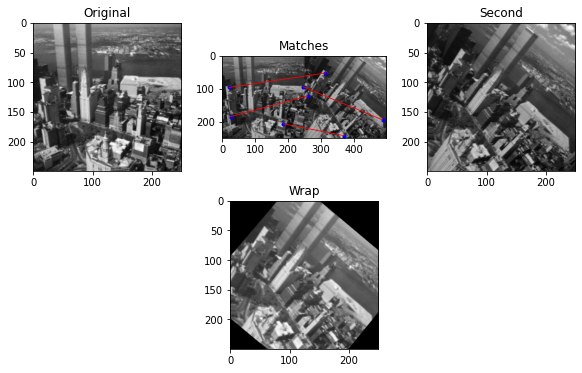

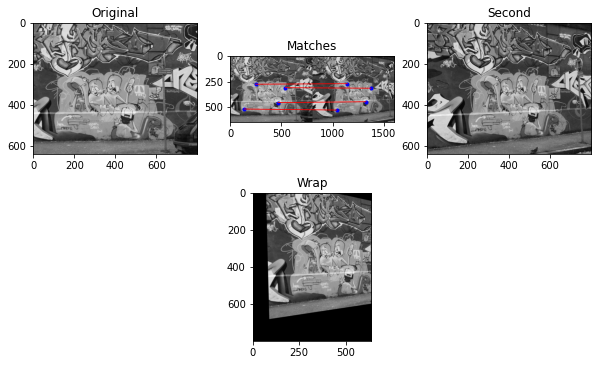

In [31]:
#As an input we get a arrays of coordinates of correspondences
#xr - array of x cordinates of first image
#yr - array of y cordinates of first image
#xt - array of x cordinates of second image
#yt - array of y cordinates of second image
def estimate_homography(correspondences):
    A = []
    #We construct the matrix A using the "formula" in the instructions
    #For each xr,yr,xt,yt we add 2 rows to the matrix A
    for xr, yr, xt, yt in correspondences:
        A.append([xr, yr, 1, 0, 0, 0, -xt * xr, -xt * yr, -xt])
        A.append([0, 0, 0, xr, yr, 1, -yt * xr, -yt * yr, -yt])
    #Perform a matrix decomposition using the SVD algorithm
    #VT is always of length 9x9 ?
    U, S, VT = np.linalg.svd(A)
    #We calculate the vector h using the formula -> 9x1 matrix
    h = VT[-1] / VT[-1,-1]
    #Reshape h to a 3x3 matrix H
    H = np.reshape(h, (3,3))
    return H


def task_a():
    triplets = [["data/newyork/newyork_a.jpg","data/newyork/newyork_b.jpg","data/newyork/newyork.txt"], ["data\graf\graf_a.jpg", "data\graf\graf_b.jpg", "data\graf\graf.txt"]]
    for image1, image2, data in triplets:
        I1 = np.asarray(Image.open(image1).convert("L")).astype(np.float64) / 255
        I2 = np.asarray(Image.open(image2).convert("L")).astype(np.float64) / 255
        #We get the correspondences from a txt file
        correspondences = np.loadtxt(data)
        #Store correspondences of the first image into points1 and second into points2
        points1 = correspondences[:,:2]
        points2 = correspondences[:,2:]

        #Calculating the homography matrix (it tells us the rotation of the image based on the correspondences ?)
        H = estimate_homography(correspondences)
        #Transform the first image to the plane of the second image
        plane = cv2.warpPerspective(I1, H, dsize=I1.shape)

        plt.figure(figsize=(10,6))
        plt.subplot(2,3,1)
        plt.imshow(I1, cmap="gray")
        plt.title("Original")

        plt.subplot(2,3,2)
        #Displaying the matching points using the given methon
        display_matches_copy(I1, points1, I2, points2)
        plt.title("Matches")

        plt.subplot(2,3,3)
        plt.imshow(I2, cmap="gray")
        plt.title("Second")
        plt.subplot(2,3,5)
        plt.imshow(plane, cmap="gray")
        plt.title("Wrap")
        plt.show()

task_a()

## Task b

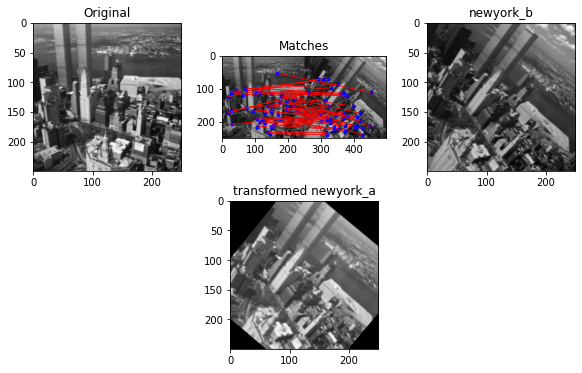

In [32]:
def ransac(correspondences, samples, error, iterations):
    #Here we will sotre the largest number of inliers and the corresponding model
    maxM = 0
    maxH = []
    #We start the ransac loop
    for i in range(0, iterations):
        #Select 4 random correpondences
        np.random.shuffle(correspondences)
        randCorr = correspondences[:samples]
        #Calculate the H for the random correspondences
        H = estimate_homography(randCorr)
        points1 = correspondences[:,:2]
        points2 = correspondences[:,2:]
        #Multiply the points coordinates with the H and calculating the error
        #We take the points of the first image, convert them to a 1x3 vector (by adding 1) -> [x,y,1]T
        points1 = np.pad(points1, ((0,0),(0,1)), "constant", constant_values=(1))
        points1 = np.expand_dims(points1,2) #Used to transpose all the vectors
        #We multiply these vectors with the H matrix and divide the result by the last vector value so we again get 1 in that position -> [x',y',1]
        points1_ = H.dot(points1) #We do the dot product between the H matrix and each vector
        points1_ = np.squeeze(points1_.T) #We transform the result into a (num of points)x3 array
        points1_ = points1_ / np.expand_dims(points1_[:,-1],1) #We divide each row by it's last element
        points1_ = points1_.astype(int) #Convert the points back to integers
        points1_ = np.delete(points1_,2,1) #We delete the last column (the colum with 1s)
        #We conpute the distance between these vectors and their corresponding matches and count how many fall within the allowed error
        distances = np.sqrt((points1_[:,0] - points2[:,0])**2 + (points1_[:,1] - points2[:,1])**2)
        M = np.where(distances < error)[0].size #We count the amount of points whose distances are lower than the allowed error
        #If the amount of valid points is higher than the current amount of valid points, we keep the new homography matrix because it's better than the old one
        if(M > maxM):
            maxM = M
            maxH = H
    return maxH
        
        


def task_b():
    I1 = np.asarray(Image.open("data/newyork/newyork_a.jpg").convert("L")).astype(np.float64) / 255
    I2 = np.asarray(Image.open("data/newyork/newyork_b.jpg").convert("L")).astype(np.float64) / 255

    points1, points2 = find_matches(I1, I2, 1)

    correspondences = np.hstack((points1,points2))
    H = ransac(correspondences, 4, 2, 100)

    plane = cv2.warpPerspective(I1, H, dsize=I1.shape)

    plt.figure(figsize=(10,6))
    plt.subplot(2,3,1)
    plt.imshow(I1, cmap="gray")
    plt.title("Original")
    plt.subplot(2,3,2)
    display_matches_copy(I1, points1, I2, points2)
    plt.title("Matches")
    plt.subplot(2,3,3)
    plt.imshow(I2, cmap="gray")
    plt.title("newyork_b")
    plt.subplot(2,3,5)
    plt.imshow(plane, cmap="gray")
    plt.title("transformed newyork_a")
    plt.show()

    # plt.imshow(I2)
    # plt.imshow(plane, alpha=0.5)
    # plt.show()

task_b()

## Task c

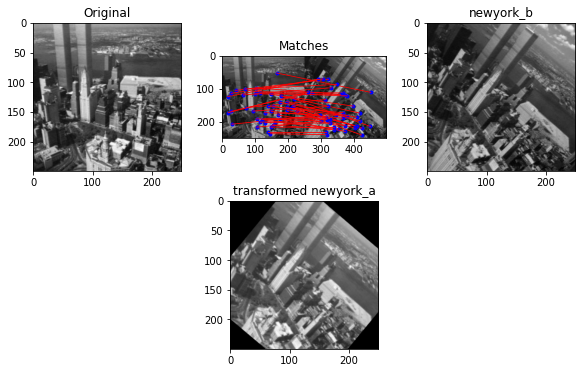

In [36]:
#The goal here is to calculate how many iterations are necesary for there to be selected an inlying model with
#s parameters atleast once with probability p 
#Lectures 4, slide 48
#Equation:  N = log(1-p)/log(1-(1-e)^s)
#number of inliers = 29, number of all correspondences = 41 -> e = 30%
#---> N = log(1-0.99)/log(1-(1-0.3)^4) = 17

def task_c():
    I1 = np.asarray(Image.open("data/newyork/newyork_a.jpg").convert("L")).astype(np.float64) / 255
    I2 = np.asarray(Image.open("data/newyork/newyork_b.jpg").convert("L")).astype(np.float64) / 255

    points1, points2 = find_matches(I1, I2, 1)

    correspondences = np.hstack((points1,points2))
    H = ransac(correspondences, 4, 2, 17)

    plane = cv2.warpPerspective(I1, H, dsize=I1.shape)

    plt.figure(figsize=(10,6))
    plt.subplot(2,3,1)
    plt.imshow(I1, cmap="gray")
    plt.title("Original")
    plt.subplot(2,3,2)
    display_matches_copy(I1, points1, I2, points2)
    plt.title("Matches")
    plt.subplot(2,3,3)
    plt.imshow(I2, cmap="gray")
    plt.title("newyork_b")
    plt.subplot(2,3,5)
    plt.imshow(plane, cmap="gray")
    plt.title("transformed newyork_a")
    plt.show()

task_c()

## Task d

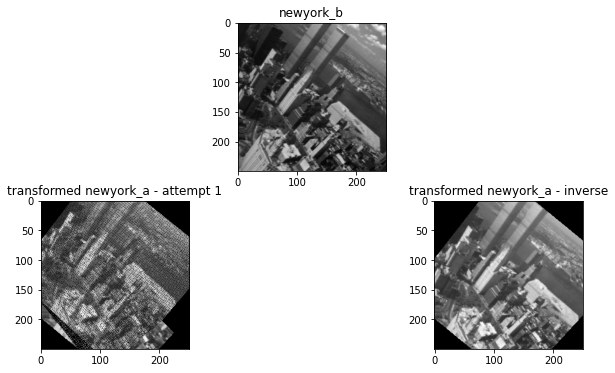

In [34]:
#The idea here was to "transform" each pixel from the original image to the warped image using the H (homography) matrix
#But because after the dot product between H and our pixel coordinates we get a float and need to round it to get a matrix index
#Multiple pixels sometimes get mapped to the same index in the new matrix (leaving some pixels missing -> artifacts)

#My idea was that for every black pixel in the new image we would inverse the coordinates and fetch the value from the original image
#to fill in the black artifacts (did not work very well, but i could see a cleaner image in the corners)
#Thats when i got the idea to delete the first part of the algorythm and just use the "reverse homography"
def warpPerspectiveAttempt1(I, H):
    Iwarp = np.zeros_like(I) #Here we will store the result
    inv_H = np.linalg.inv(H) #We inverse the H matrix because otherwise it did not work
    #For each pixel in I we do:
    for (x, y), value in np.ndenumerate(I):
        x_r = [x, y, 1] #Transform the pixel coordinates to homogenous form
        x_t = inv_H.dot(x_r) #Compute the corresponding x_t using the homography matrix
        x_t = np.round(x_t / x_t[-1]).astype(int) #Transform the x_t back to 2D space
        #Because we are rotating the image not all pixels will be placed in the new image (some will get cut off)
        if(x_t[0] >= 0 and x_t[0] < Iwarp.shape[1] and x_t[1] >= 0 and x_t[1] < Iwarp.shape[0]):
            Iwarp[x_t[0], x_t[1]] = value

    #The result currently has many artifacts
    #For every black pixel in the new image we do a reverse homography and fetch the value of the real image
    for (x,y), value in np.ndenumerate(Iwarp):
        if(value != 0):
            continue
        x_r = [x, y, 1] #Transform the pixel coordinates to homogenous form
        x_t = inv_H.dot(x_r) #Compute the corresponding x_t using the homography matrix
        x_t = np.round(x_t / x_t[-1]).astype(int) #Transform the x_t back to 2D space
        #Because we are rotating the image not all pixels will be placed in the new image (some will get cut off)
        if(x_t[0] >= 0 and x_t[0] < Iwarp.shape[1] and x_t[1] >= 0 and x_t[1] < Iwarp.shape[0]):
            Iwarp[y, x] = I[x_t[1], x_t[0]]
        


    return Iwarp

#Instead of transforming the reference image coordinates and copying the values to the new image (and loosing some pixels because of rounding floats)
#we iterate through each pixel in the new image, do a inverse transform to get the reference image coordinates and fetching the corresponding value
#We can still get some distortion (nearby pixels fetch the same reference image value) but we don't have any black pixels
def inverseWrapPerspective(I, H):
    Iwarp = np.zeros_like(I) #Here we will store the result
    inv_H = np.linalg.inv(H) #We inverse the H matrix because otherwise it did not work (tried to transpose it, did not work)
    #For each pixel in the new image we will transform the coordinates to the reference image (using inv(H))
    #And store the value of the reference image into our new image
    for y in range(0, Iwarp.shape[0]):
        for x in range(0, Iwarp.shape[1]):
            new_homog_coords = [x, y, 1] #Transform the pixel coordinates to homogenous form
            ref_homog_coords = inv_H.dot(new_homog_coords) #Compute the corresponding ref_homog_coords using the homography matrix
            ref_homog_coords = np.round(ref_homog_coords / ref_homog_coords[-1]).astype(int) #Transform the ref_homog_coords back to 2D space
            #Because we are rotating the image not all pixels will be placed in the reference image (some will get cut off)
            if(ref_homog_coords[0] >= 0 and ref_homog_coords[0] < Iwarp.shape[1] and ref_homog_coords[1] >= 0 and ref_homog_coords[1] < Iwarp.shape[0]):
                Iwarp[y, x] = I[ref_homog_coords[1], ref_homog_coords[0]]

    return Iwarp


def task_d():
    I1 = np.asarray(Image.open("data/newyork/newyork_a.jpg").convert("L")).astype(np.float64) / 255
    I2 = np.asarray(Image.open("data/newyork/newyork_b.jpg").convert("L")).astype(np.float64) / 255

    points1, points2 = find_matches(I1, I2, 1)
    correspondences = np.hstack((points1,points2))
    H = ransac(correspondences, 4, 2, 100)

    plane1 = warpPerspectiveAttempt1(I1, H)
    plane2 = inverseWrapPerspective(I1, H)


    plt.figure(figsize=(10,6))
    plt.subplot(2,3,2)
    plt.imshow(I2, cmap="gray")
    plt.title("newyork_b")
    plt.subplot(2,3,4)
    plt.imshow(plane1, cmap="gray")
    plt.title("transformed newyork_a - attempt 1")
    plt.subplot(2,3,6)
    plt.imshow(plane2, cmap="gray")
    plt.title("transformed newyork_a - inverse")
    plt.show()

task_d()